# How to Load Nanodet in PyTorch

This article is an introductory tutorial to infer nanodet with PyTorch.

**Note**, we suppose this notebook is in the root directory of nonadet!

## Install nanodet first

For us to begin with, PyTorch should be installed. TorchVision is also required since we will be using it as our model zoo.

A quick solution is to install via pip

```shell
pip install torch==1.7.1
pip install torchvision==0.8.2
```

or please refer to official site https://pytorch.org/get-started/locally/

PyTorch versions should be backwards compatible but should be used with the proper TorchVision version.

And then don't forget to install other dependencies.

```shell
pip install -r requirements.txt
```

Next enter the key part, let's install `nanodet`!

```shell
python setup.py develop
```

## Set Environmental Parameters

In [1]:
import os
import sys
import cv2
import torch
import numpy as np

# from nanodet.util import overlay_bbox_cv
from IPython.display import display
from PIL import Image

def cv2_imshow(a, convert_bgr_to_rgb=True):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
        a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
        convert_bgr_to_rgb: switch to convert BGR to RGB channel.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    # if convert_bgr_to_rgb and a.ndim == 3:
    #     if a.shape[2] == 4:
    #         a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    #     else:
    #         a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.chdir("../")

device = torch.device('cuda')
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# config_path = 'config/nanodet-plus-m_416.yml'
config_path = 'config/hawk.yml'
# model_path = 'models/nanodet-plus-m_416_checkpoint.ckpt'
model_path = 'workspace/nanodet-plus-m_lpd416/model_best/model_best.ckpt'

## Set Model

In [2]:
# Configuration and Logger
from nanodet.util import cfg, load_config, Logger
load_config(cfg, config_path)
logger = Logger(-1, use_tensorboard=False)

# Predictor
from demo import Predictor
predictor = Predictor(cfg, model_path, logger, device=device)

model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.


## Detection output visualisation

In [3]:
def overlay_bbox_cv(img, dets, class_names, score_thresh):
    all_box = []
    for label in dets:
        for bbox in dets[label]:
            score = bbox[-1]
            if score > score_thresh:
                x0, y0, x1, y1 = [int(i) for i in bbox[:4]]
                all_box.append([label, x0, y0, x1, y1, score])
    all_box.sort(key=lambda v: v[5])
    plates = []
    for box in all_box:
        label, x0, y0, x1, y1, score = box
        # color = self.cmap(i)[:3]
        color = np.array(200).astype(np.uint8).tolist()
        # text = "{}:{:.1f}%".format(class_names[label], score * 100)
        # txt_color = (0, 0, 0) if np.mean(_COLORS[label]) > 0.5 else (255, 255, 255)
        # font = cv2.FONT_HERSHEY_SIMPLEX
        # txt_size = cv2.getTextSize(text, font, 0.5, 2)[0]
        plates.append(cv2.resize(img[y0:y1, x0:x1], (94, 24)))
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)
        # cv2.rectangle(
        #     img,
        #     (x0, y0 - txt_size[1] - 1),
        #     (x0 + txt_size[0] + txt_size[1], y0 - 1),
        #     color,
        #     -1,
        # )
        # cv2.putText(img, text, (x0, y0 - 1), font, 0.5, txt_color, thickness=1)
    return img, plates


model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.
forward time: 0.569s | 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[array([[0.92444444, 0.        , 0.        ],
       [0.        , 1.54074074, 0.        ],
       [0.        , 0.        , 1.        ]])]
decode time: 0.326s | 

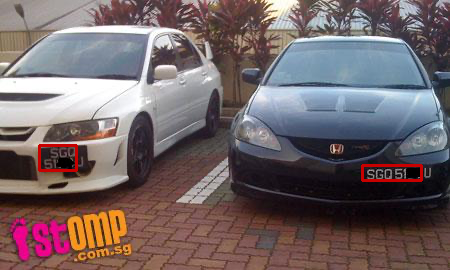

In [4]:
# Predictor
from demo import Predictor
predictor = Predictor(cfg, model_path, logger, device=device)
# image_path = '/root/vol/nanodet-torch2/tests/data/test_img.jpg'
# image_path = '/root/vol/nanodet-torch2/demo_mnn/imgs/000258.jpg'
# image_path = '/root/vol/nanodet-torch2/demo_mnn/imgs/000252.jpg'
# image_path = '/root/vol/nanodet-torch2/demo/plate2.jfif'
# image_path = '/root/vol/nanodet-torch2/demo/plate3.jpg'
# image_path = '/root/vol/datasets/open_image_v7_VOC/train/data/003a5aaf6d17c917.jpg'
image_path = '/root/vol/datasets/kaggle_car_plate/images/Cars305.png'
# image_path = '/root/vol/datasets/kaggle_car_plate/images/Cars300.png'
meta, res = predictor.inference(image_path)
result, plates = overlay_bbox_cv(meta['raw_img'][0], res[0], cfg.class_names, score_thresh=0.5)
imshow_scale = 1.0
cv2_imshow(cv2.resize(result, None, fx=imshow_scale, fy=imshow_scale))
for plate in plates:
    cv2_imshow(plate)


In [5]:
torch.min(meta['img']), torch.max(meta['img'])

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [6]:
# import fiftyone as fo
# import fiftyone.zoo as foz
# dataset = foz.load_zoo_dataset(
#               "open-images-v7",
#               split="train",
#               label_types=["detections"],
#               classes=["Vehicle registration plate"],
#               dataset_dir='/root/vol/datasets/fiftyone',
#               max_samples=60000,
#           )
# dataset = foz.load_zoo_dataset(
#               "open-images-v7",
#             #   splits="validation",
#               label_types=["detections"],
#               classes=["Vehicle registration plate"],
#               dataset_dir='/root/vol/datasets/fiftyone',
#             #   max_samples=110,
#           )
# session = fo.launch_app(dataset)